## 2. Clustering

In [1]:
import pandas as pd

### Data 

#### Description and exploration

The dataset [*Amazon Fine Food Reviews*](https://www.kaggle.com/snap/amazon-fine-food-reviews) we are working on contains the plain text of the reviews about fine food on Amazon - gathered from Oct 1999 to Oct 2012 - and the metadata associated with them. Specifically, the dataset has the following columns:  

- Id -> identifies each review
- ProductId -> identifies each product
- UserId -> identifies the author of the review
- ProfileName -> the username of the author; may be not present
- HelpfulnessNumerator -> number of users that considered the review helpful
- HelpfulnessDenominator -> number of users who judged the review helpful or not helpful
- Score -> score given to the product reviewed 
- Time -> timestamp of the review, in UNIX format
- Summary -> brief summary of the content of the review
- Text -> plain text of the review

First and foremost, we explore the dataset:

In [2]:
dataset = pd.read_csv('data/Reviews.csv')
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
dataset.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

As we can see, there are few data missing in the dataset. Since the lack of information does not affect the columns of interest of this analysis, we can ignore them.

### Data pre-processing

Before applying K-means on the dataset, it is worth to pre-process the text, in order to denoise the data and reduce the number of features. Thi last point is crucial, since the K-means algorithm suffers of the curse of dimensionality. 

The first step, as usual, is to get rid of the few informative words from the text. To do this, we write the following function:

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag



def clean_text(text, stop_words, parts_of_speech, lemmatizer):
    words_list = pos_tag(word_tokenize(text))
    result_words = []
    for word, pos in words_list:
        if (word.lower() not in stop_words) and word.isalpha() and (pos[0] in parts_of_speech):
            result_words.append(lemmatizer.lemmatize(word.lower(), pos=parts_of_speech[pos[0]]))
    return ' '.join(result_words)

Specifically, the function above transforms into lower case the words in the text, gets rid of the words that contain non alphabetical characters, lemmatizes and tags the words and filters the text according to part of speech tag assigned to each word. 

We extend the standard `nltk` stop words list with a custom list of adjectives related to opinion expression; indeed, opinion adjectives are not related to the specific kind of product, but only with the experience customers had with the product; then, these adjectives don't add any information about the kind of products and rather they are a sort of noise across the products' reviews. The list of opinion adjectives is available [here](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html).

Furthermore, since we are trying to reduce the dimensionality of the feature set as much as possible with the minimum information loss, we filter out all the words that are not nouns, verbs or adjectives; actually, we reckoned that pronouns, articles, adverbs and so on give us few or no information about the review's topic.

In [6]:
with open('./data/opinion-lexicon-English/negative-words.txt', 'r') as neg_file:
    sentiment_words = neg_file.readlines()

with open('./data/opinion-lexicon-English/positive-words.txt', 'r') as pos_file:
    sentiment_words += pos_file.readlines()

sentiment_words = [w.rstrip('\n') for w in sentiment_words] # clean the words from the \n char
kargs = {'lemmatizer': WordNetLemmatizer(),
         'stop_words': dict.fromkeys(stopwords.words('english') + sentiment_words),
         'parts_of_speech': {'N':'n', 'V':'v', 'J':'a'}
        }

dataset['Text'] = dataset.Text.apply(clean_text, **kargs)

Text cleaning left us with a bunch of blank rows. Checking them in the original dataset, we found that the text of these reviews was not informative at all, cause it contained only opinions, without the products' specifications. Then, we discard these rows from the text analysis.

In [7]:
dataset[dataset.Text == '']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59774,59775,B001NZW2V6,A3J5IKBQOHNJ8G,"S. Griffith ""truth reader""",0,1,5,1317859200,love them,
168550,168551,B0001ES9F8,A33Q5O9WGJUKWN,Seth Goldstein,0,0,5,1137283200,good,
221173,221174,B0016P26CS,A185D3IQUWHMTH,Marie,6,6,5,1271548800,Very good!,
233938,233939,B003E6COMO,A2ZE58VIDDCMR7,inna,1,2,5,1350000000,&#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#11...,
349136,349137,B0000ESTGX,A15DF0V80C6M8T,M. Hauck,6,6,5,1171065600,Boy this stuff is good!,
422125,422126,B0017AG5U6,A3AYN9U5DRLJYC,"Susan Gable ""Angelicaroses""",0,0,5,1251849600,Scrumptious,
453668,453669,B0001QYYUK,A3S7N11XRRTUU6,Bob,5,14,1,1136246400,Not worth it,
557151,557152,B001JHBRP0,A2EXSVDICJQ4QZ,Saedi Folluf,0,1,4,1341792000,"OK Rice, great Price",


In [8]:
dataset = dataset[dataset.Text != '']

Since the text pre-processing takes several minutes to be done, we save the pre-processed text in a new file, so that we can load fastly then: 

In [9]:
dataset.to_csv('data/Reviews_processed.csv', index=False)

In [10]:
dataset = pd.read_csv('data/Reviews_processed.csv')

In [11]:
dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,buy several vitality can food product find qua...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrive label jumbo salted peanut peanu...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confection century light pillowy citrus gelati...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,look secret ingredient robitussin believe find...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,taffy price wide assortment yummy taffy delive...


<br>

Before filtering the dataframe, for the future analysis, the following dataframe will be created in order to trace number of unique users writing reviews in each `ProductId`. product_id_to_unique_users dictionary contains key as productid's values as number of unique users writing review for each productid.

In [ ]:
unique_product_id = dataset.ProductId.unique()
product_id_to_unique_users = {}
for i in tqdm(range(len(unique_product_id))):
    product_id_to_unique_users[unique_product_id[i]] = dataset[dataset.ProductId == unique_product_id[i]].ProfileName.nunique()

<br>

Following variable is constructed in order to analyse reviews' score distribution in each cluster. While key contains unique ProductId's, values contain average score of the correcponding `ProductId`.

In [ ]:
product_id_to_avg_reviews_score = {}
for i in tqdm(range(len(unique_product_id))):
    product_id_to_avg_reviews_score[unique_product_id[i]] = dataset[dataset.ProductId == unique_product_id[i]].Score.mean()

In [ ]:
score_list = []
for i in range(len(dataset)):
    score_list.append(product_id_to_avg_reviews_score[dataset.ProductId.iloc[i]])
dataset_with_avg_score = dataset.copy()
dataset_with_avg_score['Average_Score'] = score_list
dataset_with_avg_score

<br>

Now, having processed the reviews' content, we aggregate them by the `ProductId`; this way, we obtain a dataset of products associated with their reviews and we can cluster them according to the text.

In [12]:
dataset = dataset.loc[:, ('ProductId', 'Text')]
dataset = dataset.groupby('ProductId')['Text'].agg(lambda x: ' '.join(x)).reset_index()
dataset.head()

,ProductId,Text
0,0006641040,day person say chicken soup go follow word sou...
1,141278509X,product archer farm drink mix mix flavored pac...
2,2734888454,dog chicken product china wont buy find chicke...
3,2841233731,book read ingredient store recipe book go spec...
4,7310172001,product health snack pup make beef liver puppy...


At this point, it is possible to compute the document-term matrix. Following the results and the conclusions in [[1]](#r:1), [[2]](#r:2), [[3]](#r:3), we decided to represent the reviews using a TF-IDF representation instead of a binary representation; indeed, to discriminate the topic of each review, it is worth to consider which words are the most informative and which are almost noise, i.e. which are present in many reviews and then no discriminative.

To compute the document-term matrix (i.e. the product-term matrix), we leverage the `TfidfVectorizer` object of the `sklearn` library.

As a first step for noise reduction, we specify in the constructor of `TfidfVectorizer` the parameter `max_df`, which allows us to filter out the words that appear in a fraction of the documents grater than the one specified; doing this, we discard the words that are stop words in our specific corpus of documents. 

Then, with the parameter `min_df` we also discard those words that are very rare and thus that may alter too much the vector representation of the documents in the space. After many tries, we found that the optimal values for these parameters are ???.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer # document vectorization and TF-IDF

vectorizer = TfidfVectorizer(max_df=0.7, min_df=5, use_idf=True) # word associated to less than 5 products
docterm_mat = vectorizer.fit_transform(dataset['Text'])

In [14]:
docterm_mat.shape[1] # number of features, that is number of words in the vocabulary

27182

As we can see, the number of features, that is the number of components of the vectors that represent the documents, is still huge.

To dramatically reduce the number of features, we apply the SVD method to the document-term matrix. We start trying with a number of components equal to 100, as suggested, and increasing this number until at least the 60% of the initial variance is retained.

In [15]:
from sklearn.decomposition import TruncatedSVD # for features reduction
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm


def estimate_components(docterm_mat, start_n, end_n, step=100):
    components_variance = {}
    fig = plt.figure(figsize=(16, 10))
    for n_components in tqdm(range(start_n, end_n, step)):
        svd = TruncatedSVD(n_components=n_components)
        svd.fit_transform(docterm_mat)
        components_variance[n_components] = round(np.cumsum(svd.explained_variance_ratio_)[-1], 5) * 100
        del svd
    plt.plot(list(components_variance.keys()), list(components_variance.values()))
    plt.xlabel('Number of components')
    plt.ylabel('Variance')
    plt.grid()
    plt.show()

100%|██████████| 9/9 [05:43<00:00, 38.18s/it]


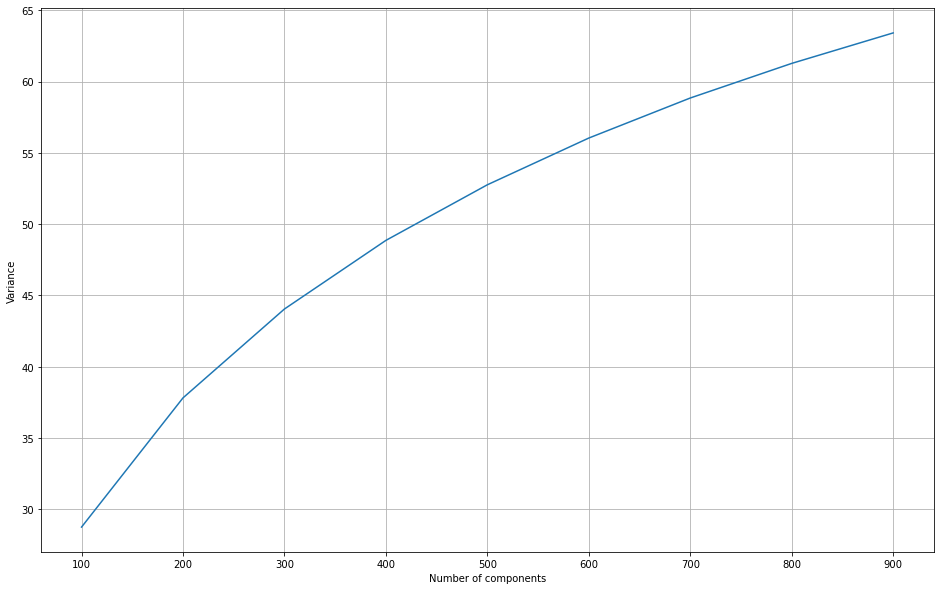

In [16]:
estimate_components(docterm_mat, 100, 1000, 100)

According to the plot above, the 60% of the variance corresponds to about 780 components. Because the plot was computed taking into account an increment of 100 components at each step and then it is an approximation, we pick 800 components, which guarantee to have more than the 60% of the variance.

As pointed out in [[4]](#r:4), K-means is known to work better on normalized features; then we pipeline the SVD method with a normalization, as in the official `sklearn` documentation. 

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(n_components=800)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
reduced = lsa.fit_transform(docterm_mat)

In [29]:
print(f'Variance with 800 components:\t{round(np.cumsum(svd.explained_variance_ratio_)[-1], 5) * 100}%')

Variance with 800 components:	61.273999999999994%


In the next section, we implement K-means and we apply it on the reduced matrix of products-terms.

<br>

### 2.1 K-means

In [19]:
# importing the libraries
import numpy as np
import random
from random import randint

In [20]:
# k : total number of the clusters
def random_centers(k, matrix):
    copy_matrix = np.copy(matrix)
    # matrix for cluster centroids
    center_matrix = np.zeros((k, len(matrix[0])))
    
    # randomly choosing k cluster centers without replacement
    for i in range(k):
        new_center_index = random.randint(0, copy_matrix.shape[0]-1)
        center_matrix[i,:] = copy_matrix[new_center_index, :]
        copy_matrix = np.delete(copy_matrix, new_center_index, 0 )
    return center_matrix

def compute_centroids(cluster_dictionary, matrix, k):
    
    cluster_dict_copy = {key:matrix[cluster_dictionary[key], :] for key in cluster_dictionary}
    
    # computes the new centroid values
    for i in range(len(cluster_dictionary.keys())):
        cluster_dict_copy[i] = np.array([cluster_dict_copy[i]])
        cluster_dict_copy[i] = np.mean(cluster_dict_copy[i][0], axis=0)
    
    new_center_matrix = np.zeros((k, len(matrix[0])))
    for i in range(len(cluster_dict_copy.keys())):
        new_center_matrix[i] = cluster_dict_copy[i]
        
    return new_center_matrix

def assignment_to_centroids(matrix, center_matrix, k):
    
    # cluster_dict key corresponds to index of clusters, values correspond to elements that belong to the cluster 
    cluster_dict = {}
    for i in range(k):
        cluster_dict[i] = []
        
    for element_idx, element in zip(range(matrix.shape[0]), matrix): # get the row (product) and its index
        min_dist_value  = np.linalg.norm(element - center_matrix[0])
        cluster_index = 0
        for i in range(1, k):
            new_dist = np.linalg.norm(element - center_matrix[i])
            if min_dist_value > new_dist:
                min_dist_value = new_dist
                cluster_index = i
        cluster_dict[cluster_index].append(element_idx)
    
    return cluster_dict

        
        
def k_means(k, matrix):
    
    center_matrix = random_centers(k, matrix)
    cluster_dict = assignment_to_centroids(matrix, center_matrix, k)
    
    while np.array_equal(center_matrix, compute_centroids(cluster_dict, matrix, k))==False:
        center_matrix = compute_centroids(cluster_dict, matrix, k)
        cluster_dict  = assignment_to_centroids(matrix, center_matrix, k)
    return cluster_dict, center_matrix


In [30]:
cluster_dict, center_matrix = k_means(25, reduced)

In [22]:
def compute_inertia(cluster_dict, center_matrix, matrix):
    inertia = 0
    for cluster in cluster_dict:
        for point_idx in cluster_dict[cluster]:
            inertia += np.sum(np.square(matrix[point_idx] - center_matrix[cluster]))
    return inertia


def elbow_method(matrix, start_n=1, end_n=50):
    end_n = end_n if end_n < matrix.shape[0] else matrix.shape[0]
    elbow = {}
    for k in tqdm(range(start_n, end_n)):
        cluster_dict, center_matrix = k_means(k, matrix)
        elbow[k] = compute_inertia(cluster_dict, center_matrix, matrix)
    return elbow

#### SciKit Learn K-means

In [23]:
from sklearn.cluster import KMeans


elbow = {}
for k in tqdm(range(1,111,10)):
    elbow_model = KMeans(n_clusters=k, init='random')
    elbow_model.fit_predict(reduced)
    elbow[k] = elbow_model.inertia_ 

100%|██████████| 11/11 [09:04<00:00, 49.49s/it]


In [24]:
def plot_elbow(elbow):
    plt.figure(figsize=(16,10))
    plt.plot(list(elbow.keys()), list(elbow.values()))
    plt.grid()
    plt.xlabel('Number of clusters')
    plt.show()

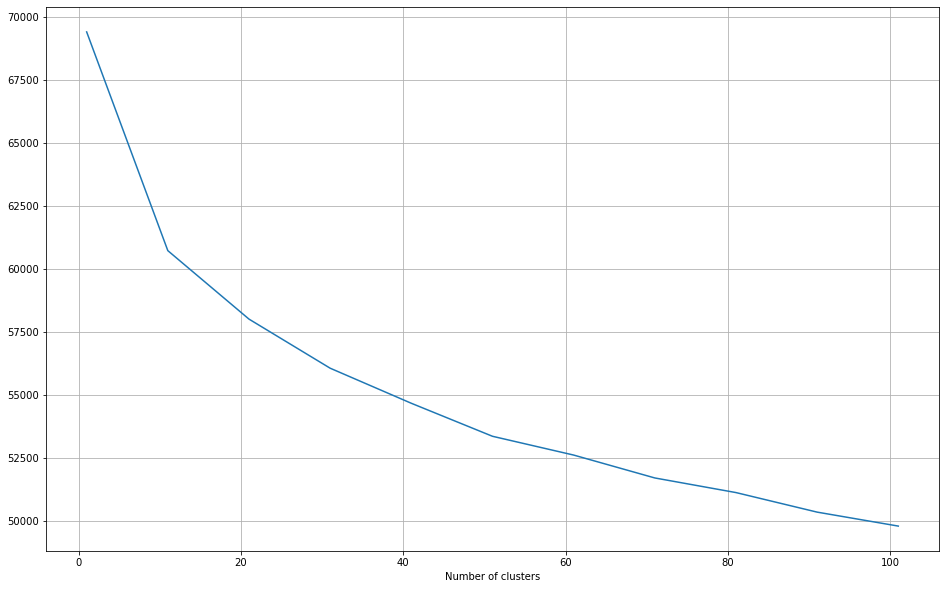

In [25]:
plot_elbow(elbow)

### 2.2 Comparison between k-means and k-means++ algorithms

In [ ]:
k = 25

In [ ]:
cluster_dict, center_matrix = k_means(k, reduced)

In [ ]:
k_means_plus = KMeans(n_clusters=k)
fit_pred = k_means_plus.fit_predict(reduced)
center_matrix_plus = k_means_plus.cluster_centers_
cluster_dict_plus ={}
for i in range(25):
    cluster_dict_plus[i]=[]
for i in range(len(fit_pred)):
    cluster_dict_plus[fit_pred[i]].append(i)

#### Inertia of k-means and k-means++

In [ ]:
# Inertia for k-means algorithm
compute_inertia(cluster_dict, center_matrix, reduced)

In [ ]:
# Inertia for k-means++ algorithm
compute_inertia(cluster_dict_plus, center_matrix_plus, reduced)

In [ ]:
# inertia(k-means)/inertia(k-means++)
compute_inertia(cluster_dict, center_matrix, reduced)/compute_inertia(cluster_dict_plus, center_matrix_plus, reduced)

Low inertia value is interpreted as a good sign of the centroid allocation in k-means algorithms. Comparison of inertia values between k-means and k-means++ algorithm shows that k-means has slightly higher inertia than the k-means++ algorithm. This increase is found as .005 which is very low amount to say that k-means performs significantly worse than the k-means++. Under the consideration of random initialization, this difference can be explained. Also, it is better to state that another run for k-means does not guarantee an optimistic scenario like this case.

#### Average distance between centroids in k-means and k-means++

In [ ]:
distance_list=[]
for i in range(len(center_matrix)):   
    for j in range(len(center_matrix)):
        if i !=j:
            distance_list.append(np.linalg.norm(center_matrix[i]-center_matrix[j]))
sum(distance_list)/len(distance_list)

In [ ]:
distance_list=[]
for i in range(len(center_matrix_plus)):   
    for j in range(len(center_matrix_plus)):
        if i !=j:
            distance_list.append(np.linalg.norm(center_matrix_plus[i]-center_matrix_plus[j]))
sum(distance_list)/len(distance_list)

It can be seen that average distance between centroids has larger amount in k-means++ than the k-means algorithm. High distance value between the centroids is a good sign of the fitted model. It can be also seen that, found values show support of good fit in the k-means algorithm. We can say that random initialization does not lead bad centroid allocation for this case.

### 2.3 Analyse the obtained clusters

#### 2.3.1 Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a visualization called word cloud.

In [49]:
from mpl_toolkits.axes_grid1 import ImageGrid
from wordcloud import WordCloud

def get_word_cloud(center_matrix, svd, vectorizer, n_words=50):
    center_matrix_inv = svd.inverse_transform(center_matrix)
    terms = vectorizer.get_feature_names()
    word_cloud = WordCloud()
    fig = plt.figure(figsize=(16,30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(round(center_matrix.shape[0]/4 + 0.5), 4),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )
    centroids = np.argsort(center_matrix_inv)[:, ::-1]
    for i, ax in zip(range(center_matrix.shape[0]), grid):
        top_term_freq = {}
        for w_idx in centroids[i, :n_words]:
            top_term_freq[terms[w_idx]] = center_matrix_inv[i][w_idx]
        word_cloud.generate_from_frequencies(top_term_freq)
        ax.set_title(f'Cluster {i+1}')
        ax.axis("off")
        ax.imshow(word_cloud, interpolation="bilinear")
    plt.show()

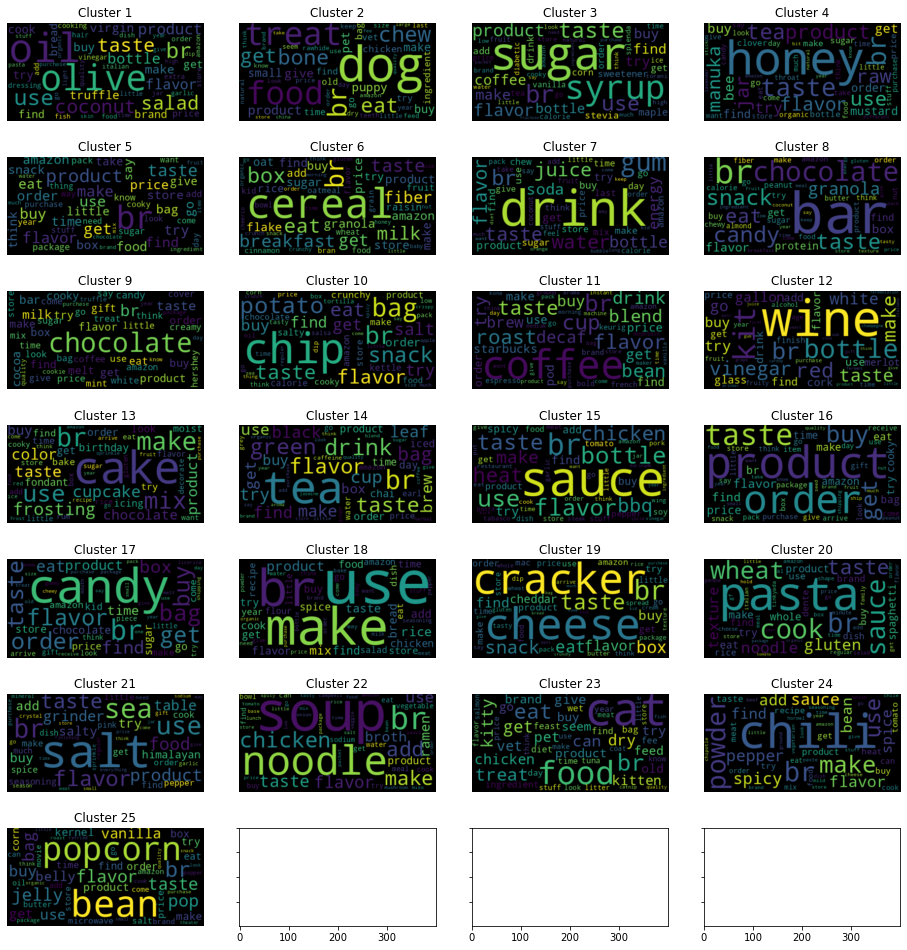

In [50]:
get_word_cloud(center_matrix, svd, vectorizer)

#### 2.3.2 Provide the number of product in each cluster

In [ ]:
# Cluster size for each cluster in sorted order for k-means
cluster_size = []
for i in cluster_dict:
    cluster_size.append(len(cluster_dict[i]))
cluster_size.sort()

# Cluster size for each cluster in sorted order for k-means++
cluster_size_plus = []
for i in cluster_dict_plus:
    cluster_size_plus.append(len(cluster_dict_plus[i]))
cluster_size_plus.sort()

plt.plot(cluster_size, 'r')
plt.plot(cluster_size_plus, 'g')
plt.xlabel("ID of The Cluster")
plt.ylabel("Number of products")
legend = ['k means', 'k means++']
plt.legend(legend)
plt.show()

From the above plot, number of elements in the clusters for k-means and k-means++ algorithms are found close to each other. In order to have a nice-shaped graph and make an easy comparies both data are sorted.

#### 3.3 Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant!

In [ ]:
avg_score_in_each_cluster_k_means = [0] * k
for i in range(k):
    for j in range(len(cluster_dict[i])):
        avg_score_in_each_cluster_k_means[i] += dataset_with_avg_score.iloc[cluster_dict[i][j]].Average_Score
    avg_score_in_each_cluster_k_means[i] /= len(cluster_dict[i])

plt.plot(avg_score_in_each_cluster_k_means, 'r')
plt.xlabel("ID of the Clusters")
plt.ylabel("Reviews' Average Score")
plt.title('k-means')
plt.show()

Above plot is created to observe the Reviews' Average Score by ID of the clusters in k-means algorithm. Range varies between 4.4 to 3.7, 14% range distance shows a good distribution of the reviews between clusters.

In [ ]:
avg_score_in_each_cluster_k_means_plus = [0] * k
for i in range(k):
    for j in range(len(cluster_dict_plus[i])):
        avg_score_in_each_cluster_k_means_plus[i] += dataset_with_avg_score.iloc[cluster_dict_plus[i][j]].Average_Score
    avg_score_in_each_cluster_k_means_plus[i] /= len(cluster_dict_plus[i])

plt.plot(avg_score_in_each_cluster_k_means_plus, 'g')
plt.xlabel("ID of the Clusters")
plt.ylabel("Reviews' Average Score")
plt.title('k-means++')
plt.show()

Above plot is created to observe the Reviews' Average Score by ID of the clusters in k-means++ algorithm. Range varies between 4.47 to 3.6, 17% range distance shows a good distribution of the reviews between clusters.

In the below, distribution comparison can be found for both k-means and k-means++ algorithms and cluster by cluster:

In [ ]:
clusters_k_means = []
for i in range(k):
    cluster = []
    for j in range(len(cluster_dict[i])):
        cluster.append(dataset_with_avg_score.iloc[cluster_dict[i][j]].Average_Score)
    clusters_k_means.append(cluster)

clusters_k_means_plus = []
for i in range(k):
    cluster = []
    for j in range(len(cluster_dict_plus[i])):
        cluster.append(dataset_with_avg_score.iloc[cluster_dict_plus[i][j]].Average_Score)
    clusters_k_means_plus.append(cluster)

In [ ]:
def compare_2_groups(arr_1, arr_2, alpha):
    stat, p = ttest_ind(arr_1, arr_2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')


<br>

## 3. Algorithmic question

**Theorem.** Let $A$ be an array of $n$ integers and let $s$ and $b$ be the minimum $\min\{A\}$ and the maximum $\max\{A\}$ of $A$, respectively.

Then, defined $r = b - s$, we can prove that $A$ can be sorted in $\mathbf{O}(n+r)$ time.

**Proof.**

To prove this statement, let us consider the *Counting sort* algorithm, which assumes that it is given as input a set of integers in the range $[h,h+k]$, $\forall h,k\in \mathbb{N}$ where $h \lt k$. Then, for each number $x$, it determines how many elements are less than $x$ and places $x$ into the right position in the output array. It requires an extra array $C$ of dimension $r$.

![](utils/counting_sort.png)

Analyzing the algorithm, lines $1$ and $2$, i.e. the research of the minimum and the maximum of $A$, take $\mathbf{O}(n)$ each. Scanning $C$ takes $\mathbf{O}(r)$ and placing the sorted numbers in $B$ takes again $\mathbf{O}(n)$. Then, the overall complexity of *Counting Sort* is $\mathbf{O}(n) + \mathbf{O}(r) = \mathbf{O}(n+r)$.

In the end, we have proved that $A$ can be sorted in $\mathbf{O}(n+r)$.

**Note:** due to some Latex visualization issues related to the render engine of GitHub, the Latex output was included as an image. The complete source of this answer can be found in `utils/Algorithmic_question.ipynb`.

---

## References

<div id='r:1'>[1] V. K. Singh, N. Tiwari and S. Garg, "Document Clustering Using K-Means, Heuristic K-Means and Fuzzy C-Means," 2011 International Conference on Computational Intelligence and Communication Networks, Gwalior, 2011, pp. 297-301, doi: 10.1109/CICN.2011.62.</div><br>

<div id='r:2'>[2] Anna Huang, "Similarity Measures for Text Document Clustering", NZCSRSC 2008, April 2008, Christchurch, New Zeland, doi: 10.1.1.332.4480.</div><br>

<div id='r:3>[3]'>[3] Lucas de Sá, "Text Clustering with K-Means", Medium, Dec 18 2019,  https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b</div><br>

<div id='r:4'>[4] "Clustering text documents using k-means", ScikitLearn, https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py</div>